# Price per square meter as a function of apartment size in the Finnish real-estate market

Based on browsing apartment ads it seems that small apartments are more expensive per square meter than larger apartments. I wanted to find out if this is true, and quantify the results.

The data is scraped from https://asuntojen.hintatiedot.fi/haku/.

The prediction process consists of preprocessing the data and using Random Forest and Light GBM classifiers

## Part 1: Gathering data

In [1]:
#Main package imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#ML data processing
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler

#ML models and hyperparameter optimisation
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

/Users/mathias/anaconda3/lib/python3.6/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#TODO

# 1. Avoid '\xa0 in parsing'
# 2. Cat boost for categorical variables?
# 3. Try dropping postal codes with few apartments

In [3]:
def parse_website(postal_code):
    '''
    Connects to asuntojen.hintatiedot.fi and pulls data on sold apartments from the last 12 months.
    
    
    Parameters:
    postal_code (str): Postal area code to get data for
    
    Returns:
    Nested list with apartment data
    
    '''
    URL = 'https://asuntojen.hintatiedot.fi/haku/?c=&cr=1&ps=' + postal_code + '&nc=0&amin=&amax=&renderType=renderTypeTable&search=1'
    
    page = requests.get(URL)

    soup = BeautifulSoup(page.content, 'html.parser')

    main_table = soup.find(id='mainTable')

    apartments = main_table.find_all('tr', class_="")
    
    
    local_area_apartments = []
    for a in apartments[4:-2]: # First 4 and last 2 'td' tags are not apartment information
        elements = a.find_all('td')

        parsed_apartment = [element.text.replace("\xa0", "") for element in elements]
        
        if len(parsed_apartment) < 2:
            continue
        parsed_apartment[3] = parsed_apartment[3].replace(",", ".") #Change to international decimal delimiter
        parsed_apartment[10] = parsed_apartment[10].split("\t")[0] #Weird formatting in source website
        parsed_apartment.append(postal_code)
        local_area_apartments.append(parsed_apartment)
        
    return local_area_apartments
    

In [4]:
#Create list of postal codes
#TODO Include only real postal codes, now contains some non-existant
parsed_apartments = []
postal_codes_helsinki = ['00'+str(10*i) for i in range(10,100)] #All Helsinki postal codes
postal_codes_espoo = ['0'+str(10*i) for i in range(210,298)]
postal_codes_vantaa = ['0'+str(10*i) for i in range(120,177)]

postal_codes = postal_codes_helsinki + postal_codes_espoo + postal_codes_vantaa

#Loop over postal codes and scrape data
count = 0
for postal_code in postal_codes:
    apartments = parse_website(postal_code)
    for apartment in apartments:
        parsed_apartments.append(apartment)
    if count%10 == 0:
        print(f"Parsed {count}/{len(postal_codes)} postal codes")
    count += 1
print("Parsed all postal codes")

Parsed 0/235 postal codes
Parsed 10/235 postal codes
Parsed 20/235 postal codes
Parsed 30/235 postal codes
Parsed 40/235 postal codes
Parsed 50/235 postal codes
Parsed 60/235 postal codes
Parsed 70/235 postal codes
Parsed 80/235 postal codes
Parsed 90/235 postal codes
Parsed 100/235 postal codes
Parsed 110/235 postal codes
Parsed 120/235 postal codes
Parsed 130/235 postal codes
Parsed 140/235 postal codes
Parsed 150/235 postal codes
Parsed 160/235 postal codes
Parsed 170/235 postal codes
Parsed 180/235 postal codes
Parsed 190/235 postal codes
Parsed 200/235 postal codes
Parsed 210/235 postal codes
Parsed 220/235 postal codes
Parsed 230/235 postal codes
Parsed all postal codes


In [5]:
#Convert scraped data into pandas dataframe
columns = ['neighborhood', 'apartment_type', 'house_type', 'sqm', 'price', 'price_per_sqm', 'year_built', 'floor', 'elevator', 'condition', 'plot_ownership', 'energy_class', 'postal_code']
df = pd.DataFrame(parsed_apartments,columns=columns)

to_numeric_columns = ['sqm', 'price', 'price_per_sqm', 'year_built']
for column in to_numeric_columns:
    df[column] = pd.to_numeric(df[column])

#Outputting data to .csv file in order to save data and avoid the need to pull data again
df.to_csv("apartment_prices.csv")

In [6]:
df.head()

,neighborhood,apartment_type,house_type,sqm,price,price_per_sqm,year_built,floor,elevator,condition,plot_ownership,energy_class,postal_code
0,Etu-töölö,"1h, avok, kph, kht",kt,24.0,217000,9042,1929,6/7,on,hyvä,oma,E2018,00100
1,Etu-töölö,"1h, kk",kt,28.0,260000,9286,1927,1/6,on,tyyd.,oma,F2013,00100
2,Etu-töölö,1h+k,kt,41.0,320000,7805,1911,2/5,ei,hyvä,oma,E2018,00100
3,Töölö,"1h,ikk.kk,kh",kt,23.0,226000,9826,1934,1/3,ei,tyyd.,oma,D2013,00100
4,Keskusta,"1h,k",kt,47.9,500000,10438,1905,3/3,ei,tyyd.,oma,G,00100


In [7]:
df.describe()

,sqm,price,price_per_sqm,year_built
count,4788.000000,4.788000e+03,4788.000000,4788.000000
mean,66.192607,2.600758e+05,4347.590434,1981.800543
std,33.969017,1.311311e+05,2072.094916,27.545228
min,6.000000,1.466000e+03,74.000000,1850.000000
25%,45.000000,1.720000e+05,2897.000000,1964.000000
50%,59.000000,2.350000e+05,3860.000000,1982.000000
75%,79.500000,3.175000e+05,5370.250000,2006.000000
max,323.100000,1.678000e+06,33228.000000,2021.000000


## Part 2: Data visualisation and preprocessing

In [8]:
# We will use house type, sqm, price, year_built, floor, elevator, condition, plot_ownership and postal_code
# To predict the price_per_sqm
cols = ['price_per_sqm','house_type', 'sqm', 'price', 'year_built', 'floor', 'elevator', 'condition', 'plot_ownership', 'postal_code']
df_ml = df[cols].copy(deep=True)
df_ml.replace('', np.nan, inplace=True) #Replace empty cells with nan for easier use of built-in methods

#Find columns with missing values
columns_with_missing_values = [col for col in df_ml.columns if df_ml[col].isna().any()]

for col in columns_with_missing_values:
    print(f"Count of values in column {col} = {df_ml[df_ml[col].isna()].index.size}")

#As the count of rows containing missing values is somewhat low, the corresponding rows are dropped
df_ml.dropna(axis=0, inplace=True)

Count of values in column floor = 64
Count of values in column condition = 50
Count of values in column plot_ownership = 59


Text(0.5, 0, 'Year built (apartment buildings only)')

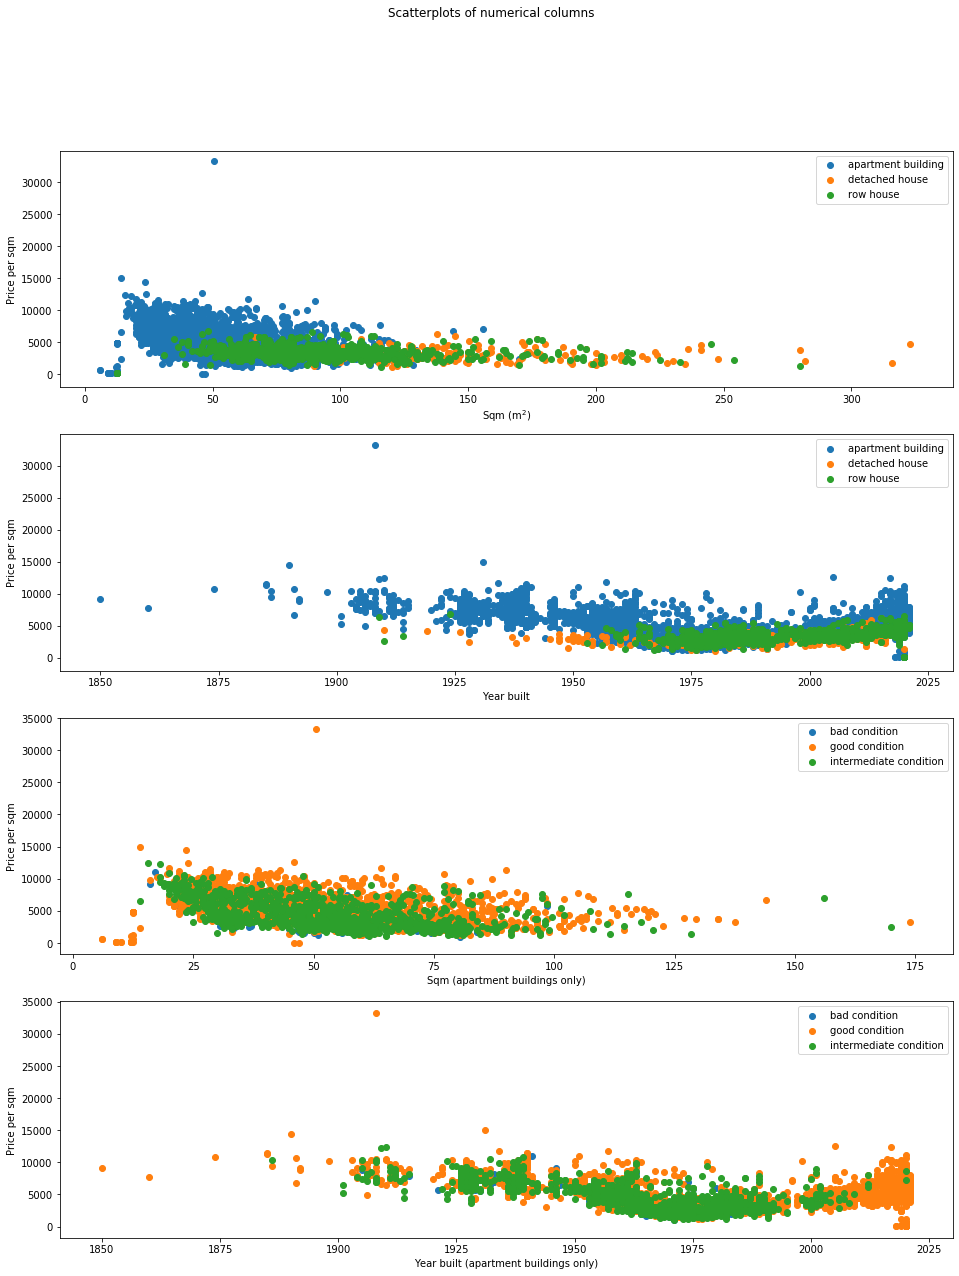

In [9]:
groups_house_types = df_ml.groupby('house_type') # For plotting different colours depending on house type
groups_condition_in_kt = df_ml[df_ml['house_type']=='kt'].groupby('condition') # Colours depending on condition
fig, axs = plt.subplots(4, figsize=(16, 20))
fig.suptitle('Scatterplots of numerical columns')

for name, group in groups_house_types:
    axs[0].scatter(group['sqm'], group['price_per_sqm'], label=name)
    axs[1].scatter(group['year_built'], group['price_per_sqm'], label=name)

for name, group in groups_condition_in_kt:
    axs[2].scatter(group['sqm'], group['price_per_sqm'], label=name)
    axs[3].scatter(group['year_built'], group['price_per_sqm'], label=name)
    
axs[0].legend(['apartment building', 'detached house', 'row house'])
axs[1].legend(['apartment building', 'detached house', 'row house'], loc=1)
axs[2].legend(['bad condition', 'good condition', 'intermediate condition'])
axs[3].legend(['bad condition', 'good condition', 'intermediate condition'], loc=1)

for ax in axs:
    ax.set_ylabel('Price per sqm')
axs[0].set_xlabel('Sqm (m$^2$)')
axs[1].set_xlabel('Year built')
axs[2].set_xlabel('Sqm (apartment buildings only)')
axs[3].set_xlabel('Year built (apartment buildings only)')

The first subplot does show higher prices per square meter for smaller apartments. It also suggests that apartment buildings (kt) generally have smaller apartments than separate houses (ok) and row houses (rt).

It is also obvious that there is an outlier with over 30k€ per sqm, as well as many new good condition apartments that are very cheap. These are removed below

In [10]:
outliers = df_ml[(df_ml['price_per_sqm'] > 30000) | (df_ml['price_per_sqm'] < 400)]
print(f"Count of outliers {outliers.index.size}")

# Drop the outlier data
df_ml.drop(outliers.index, axis=0, inplace=True)
outliers

Count of outliers 21


,price_per_sqm,house_type,sqm,price,year_built,floor,elevator,condition,plot_ownership,postal_code
140,33228,kt,50.5,1678000,1908,5/5,ei,hyvä,oma,00140
918,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
926,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
928,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
929,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
931,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
932,120,rt,12.5,1500,2020,1/2,ei,hyvä,vuokra,00410
3248,150,kt,10.0,1502,2020,1/1,on,hyvä,vuokra,02430
3249,123,kt,12.0,1480,2020,1/1,on,hyvä,vuokra,02430
3250,123,kt,12.0,1480,2020,1/1,on,hyvä,vuokra,02430


Text(0.5, 1.0, 'Most frequent')

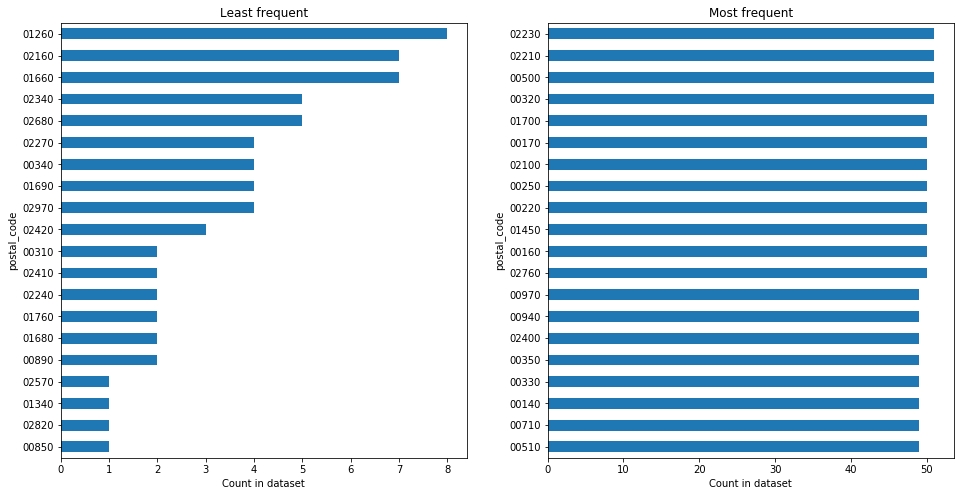

In [11]:
plt.figure()
plt.subplot(121)
df_ml.groupby('postal_code')['price'].count().sort_values()[:20].plot.barh(figsize=(16,8))
plt.xlabel('Count in dataset')
plt.title('Least frequent')

plt.subplot(122)
df_ml.groupby('postal_code')['price'].count().sort_values()[-20:].plot.barh(figsize=(16,8))
plt.xlabel('Count in dataset')
plt.title('Most frequent')

In [12]:
df_ml.groupby('postal_code')['price'].count().sort_values().size

157

Text(0, 0.5, 'Count of postal code')

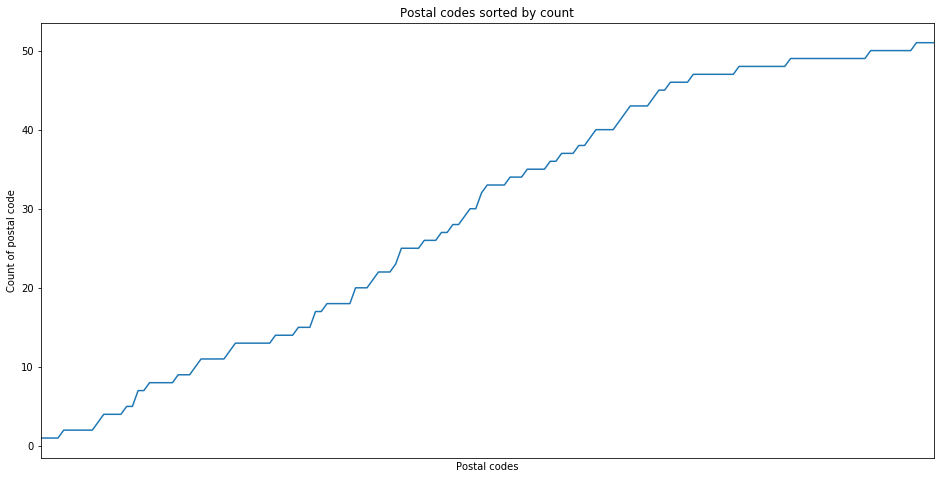

In [13]:
fig, ax = plt.subplots(figsize=(16,8))
df_ml.groupby('postal_code')['price'].count().sort_values().plot()
ax.set_title('Postal codes sorted by count')
ax.set_xticks([])
ax.set_xlabel('Postal codes')
ax.set_ylabel('Count of postal code')

There are postal codes with very few rows in the dataset. As they are categorical features, it is not obvious whether or not dropping the corresponding rows yield the best estimates. However, the predictions for the postal codes containing very few rows will not be good.

In [14]:
def parse_floor(row):
    '''
    Converts the string describing current and total floors to usable features.
    '''
    floors = row['floor'].split('/')
    try:
        row['floors'] = float(floors[1])
        row['current_floor'] = float(floors[0])
        row['floor_ratio'] = float(floors[0])/float(floors[1])
    except:
        pass
    return row

df_ml['floors'] = pd.Series()
df_ml['current_floor'] = pd.Series()
df_ml['floor_ratio'] = pd.Series()

df_ml = df_ml.apply(parse_floor, axis='columns')

In [15]:

features = df_ml.drop(['price_per_sqm', 'floor', 'price'], axis=1)
labels = df_ml['price_per_sqm']

features_train, features_test, labels_train, labels_test = train_test_split(features, labels, random_state=0) 

In [16]:
features_train

,house_type,sqm,year_built,elevator,condition,plot_ownership,postal_code,floors,current_floor,floor_ratio
121,kt,57.5,1915,on,hyvä,oma,00140,7.0,1.0,0.142857
265,kt,34.5,1971,on,hyvä,oma,00180,5.0,4.0,0.800000
608,kt,27.0,1961,ei,hyvä,oma,00320,3.0,1.0,0.333333
1815,kt,53.5,1982,ei,tyyd.,oma,00730,3.0,2.0,0.666667
921,rt,72.0,2020,ei,hyvä,vuokra,00410,2.0,1.0,0.500000
...,...,...,...,...,...,...,...,...,...,...
1061,kt,35.0,1930,on,hyvä,oma,00500,7.0,3.0,0.428571
3382,kt,121.0,2000,on,hyvä,oma,02600,5.0,5.0,1.000000
1695,rt,72.0,2019,ei,hyvä,oma,00700,2.0,1.0,0.500000
2688,kt,102.0,2006,on,hyvä,oma,00990,7.0,3.0,0.428571


In [17]:
numerical_cols = ['sqm', 'year_built', 'floors', 'current_floor']
ordinal_cols = ['elevator', 'condition', 'plot_ownership']
categorical_cols = ['house_type', 'postal_code']

ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoder())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])
minmax_scaler = Pipeline(steps=[('minmax', MinMaxScaler(feature_range=(0,1)))])

preprocessor = ColumnTransformer(
    transformers = [
        ('ord', ordinal_transformer, ordinal_cols),
        ('cat', categorical_transformer, categorical_cols),
        ('minmax', minmax_scaler, numerical_cols)
    ])



## Part 3: Exploring machine learning algorithms

### Part 3.1: Random forest

In [21]:
random_forest = RandomForestRegressor(n_estimators=100)
random_forest_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model', random_forest)])
random_forest_pipeline.fit(features_train, labels_train)

score = cross_val_score(random_forest_pipeline, features_train, labels_train, cv=5, scoring='r2')
print(f"R2 scores in cross validation: {score}")

R2 scores in cross validation: [0.84515069 0.84419878 0.85834171 0.86207915 0.8594271 ]


In [23]:
%%capture
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
parameters = {
    'model__n_estimators': [10*i for i in range(1,20)],
    'model__max_features': ['auto', 'sqrt'],
    'model__max_depth': [10*i for i in range(1,10)]+[None],
    'model__min_samples_split': [2, 5, 10],
    'model__min_samples_leaf': [1, 2, 4],
#    'bootstrap': [True, False]
}
CV = RandomizedSearchCV(estimator=random_forest_pipeline, param_distributions=parameters, scoring = 'r2', cv=50, n_iter=2, verbose=1)
CV.fit(features_train, labels_train)

In [24]:
print(CV.best_params_)
random_forest_pipeline.set_params(**CV.best_params_)
random_forest_pipeline.score(features_test, labels_test)

{'model__n_estimators': 120, 'model__min_samples_split': 10, 'model__min_samples_leaf': 1, 'model__max_features': 'auto', 'model__max_depth': 10}


0.8449238563506084

### Part 3.2: LightGBM

In [25]:
lgbm = LGBMRegressor()

lgbm_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                ('model_lgbm', lgbm)])

lgbm_pipeline.fit(features_train, labels_train)

lgbm_score = cross_val_score(lgbm_pipeline, features_train, labels_train, cv=5, scoring='r2')

lgbm_score

array([0.84647695, 0.84984548, 0.84003419, 0.85462859, 0.83060262])

In [26]:
lgbm_parameters_model_complexity = {
    'model_lgbm__num_leaves': [8, 16, 32, 64, 128],
    'model_lgbm__min_data_in_leaf': [2, 4, 8, 16, 32],
    'model_lgbm__max_depth': [8, 16, 32, 64, 128, -1],
}

lgbm_parameters_training_speed = {
    'model_lgbm__learning_rate': np.logspace(-3, 0, 10), 
}

CV_lgbm = RandomizedSearchCV(estimator=lgbm_pipeline, param_distributions=lgbm_parameters_model_complexity, scoring = 'r2', cv=5, n_iter=100, verbose=1)
CV_lgbm.fit(features_train, labels_train)
lgbm_pipeline.set_params(**CV_lgbm.best_params_)
lgbm_first_cv_params = CV_lgbm.best_params_
print(CV_lgbm.best_params_)

CV_lgbm = RandomizedSearchCV(estimator=lgbm_pipeline, param_distributions=lgbm_parameters_training_speed, scoring = 'r2', cv=5, n_iter=10, verbose=1)
CV_lgbm.fit(features_train, labels_train)

CV_lgbm.best_params_

Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 500 out of 500 | elapsed:  1.3min finished


{'model_lgbm__num_leaves': 64, 'model_lgbm__min_data_in_leaf': 2, 'model_lgbm__max_depth': 32}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:   11.7s finished


{'model_lgbm__learning_rate': 0.21544346900318823}

In [27]:
lgbm_pipeline.set_params(**CV_lgbm.best_params_)
lgbm_pipeline.score(features_test, labels_test)

0.8411164266831546

### Part 3.3: Cat Boost (or LightGBM with categorical columns)

In [28]:
#TODO

## Part n: Below testing, unfinished parts

In [29]:
# Example apartments for fun

known_apts = {'house_type' : ['kt', 'rt', 'rt'],
        'sqm': [42, 75, 115],
        'year_built': [1927, 2019, 1991],
        'elevator': ['on', 'ei', 'ei'],
        'condition': ['hyvä', 'hyvä', 'tyyd.'],
        'plot_ownership':['oma', 'vuokra', 'oma'],
        'postal_code':['00100', '02740', '00740'],
        'floors':[7, 2, 2],
        'current_floor':[3, 2, 2],
        'floor_ratio':[3/7, 1, 1]}
known_apts_names = ['mathias', 'harry', 'phki']

known_apartments = pd.DataFrame.from_dict(known_apts)

random_forest_pipeline.predict(known_apartments)

array([8173.21      , 3910.33884127, 2748.68      ])

In [30]:
known_apts_rf = random_forest_pipeline.predict(known_apartments)
known_apts_lgbm = lgbm_pipeline.predict(known_apartments)

for i in range(len(known_apts_names)):
    print(f"Apartment: {known_apts_names[i]}")
    print(f"Random Forest: {known_apts_rf[i]:.0f}\nLGBM: {known_apts_lgbm[i]:.0f}\n")


Apartment: mathias
Random Forest: 8173
LGBM: 8260

Apartment: harry
Random Forest: 3910
LGBM: 4030

Apartment: phki
Random Forest: 2749
LGBM: 2573

